# Installation of packages

In [ ]:
!pip install rioxarray stackstac pystac-client planetary-computer odc-stac rasterio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.9/61.9 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.3/64.3 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.4/41.4 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.4/89.4 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 34.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 155.1/155.1 kB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.2/194.2 kB 12.9 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np

# Reading csv files

In [ ]:
submission_df = pd.read_csv("Training_data.csv")

In [ ]:
building_data = pd.read_csv('Building_footprint_data.csv')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Extracting satellite data from the given paths stored in Google drive as Geotoiff files

In [ ]:
landsat_path = '/content/drive/MyDrive/EY AI 2025 challenge/Landsat_LST.tiff'
sentinel_path = '/content/drive/MyDrive/EY AI 2025 challenge/S2_median_composite.tiff'
training_path = '/content/drive/MyDrive/EY AI 2025 challenge/Training_data.csv'

In [ ]:
import pandas as pd
import rioxarray as rxr
from pyproj import Proj, Transformer
from tqdm import tqdm

def map_satellite_data(sentinel_path, landsat_path, csv_path):
    # Load the GeoTIFF data for Sentinel and Landsat
    sentinel_data = rxr.open_rasterio(sentinel_path)
    landsat_data = rxr.open_rasterio(landsat_path)

    # Ensure CRS matches
    sentinel_crs = sentinel_data.rio.crs
    landsat_crs = landsat_data.rio.crs

    # Read the CSV file with latitudes and longitudes
    submission_df = pd.read_csv(csv_path)
    latitudes = submission_df['Latitude'].values
    longitudes = submission_df['Longitude'].values

    # Define the coordinate transformation from EPSG:4326 (lat/lon) to the CRS of Sentinel and Landsat
    transformer_sentinel = Transformer.from_proj(Proj(init='epsg:4326'), Proj(sentinel_crs))
    transformer_landsat = Transformer.from_proj(Proj(init='epsg:4326'), Proj(landsat_crs))

    # Transform latitudes and longitudes into the CRS of the Sentinel and Landsat datasets
    x_sentinel, y_sentinel = transformer_sentinel.transform(longitudes, latitudes)
    x_landsat, y_landsat = transformer_landsat.transform(longitudes, latitudes)

    # Initialize lists to store band values
    sentinel_band_values = {f'Sentinel_B{band}': [] for band in [14, 15, 16, 18]}  # Bands 12-20 for Sentinel
    landsat_band_values = {f'Landsat_B{band}': [] for band in [7, 8, 9, 10, 11, 15, 17]}  # Bands 7-16 for Landsat

    # Extract band values for Sentinel and Landsat
    for lat, lon in tqdm(zip(latitudes, longitudes), total=len(latitudes), desc="Mapping values"):

        # Sentinel: Extract bands 12 to 20
        for band in list([14, 15, 16, 18]):
            band_value = sentinel_data.sel(x=lon, y=lat, band=band, method="nearest").values
            sentinel_band_values[f'Sentinel_B{band}'].append(band_value)

        # Landsat: Extract bands 7 to 16
        for band in list([7, 8, 9, 10, 11, 15, 17]):
            band_value = landsat_data.sel(x=lon, y=lat, band=band, method="nearest").values
            landsat_band_values[f'Landsat_B{band}'].append(band_value)

    # Create DataFrame with combined bands for Sentinel and Landsat
    df_combined = pd.DataFrame(sentinel_band_values)
    df_combined = pd.concat([df_combined, pd.DataFrame(landsat_band_values)], axis=1)

    df_final = pd.concat([submission_df[['UHI Index']], df_combined], axis=1)

    return df_final

In [ ]:
val_data = map_satellite_data(sentinel_path, landsat_path, training_path)

/usr/local/lib/python3.11/dist-packages/pyproj/crs/crs.py:143: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/usr/local/lib/python3.11/dist-packages/pyproj/crs/crs.py:143: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
Mapping values: 100%|██████████| 11229/11229 [04:35<00:00, 40.69it/s]


# Merging the val_data with Building foot print data

In [ ]:
import geopandas as gpd
from shapely.geometry import Point
import pandas as pd

# Assuming val_data contains the mapped satellite features but no explicit 'Longitude' and 'Latitude' columns

# If val_data already has columns that indirectly reference coordinates (like "row", "column" or any pixel data)
# We would need to derive or load that information. If not, I'll assume the coordinates are available somewhere else.

# Let's assume you have the coordinates from the submission CSV and will merge that with val_data.

# Load your coordinates from the submission file (if separate)
submission_df  # Assuming you have a file with latitude/longitude

# Ensure that the coordinates are in the correct format (round them for consistency)
submission_df['Longitude'] = submission_df['Longitude'].round(6)
submission_df['Latitude'] = submission_df['Latitude'].round(6)

# Assuming 'val_data' contains only satellite features, and you have a one-to-one mapping with submission_df
# Let's merge the coordinates from submission_df with val_data
val_data_with_coords = pd.concat([val_data, submission_df[['Longitude', 'Latitude']]], axis=1)

# Convert val_data_with_coords to GeoDataFrame (this will include your satellite data and the coordinates)
geometry = [Point(xy) for xy in zip(val_data_with_coords['Longitude'], val_data_with_coords['Latitude'])]
val_gdf = gpd.GeoDataFrame(val_data_with_coords, geometry=geometry, crs="EPSG:4326")

# Convert Building Footprint to GeoDataFrame
building_geometry = [Point(xy) for xy in zip(building_data['longitude'], building_data['latitude'])]
building_gdf = gpd.GeoDataFrame(building_data, geometry=building_geometry, crs="EPSG:4326")

# Use nearest join to merge val_data with building data based on proximity of coordinates
joined_data = gpd.sjoin_nearest(val_gdf, building_gdf, how='left', distance_col="distance")

# Drop unnecessary columns (e.g., index_right and geometry)
joined_data = joined_data.drop(columns=['index_right', 'geometry'])

/usr/local/lib/python3.11/dist-packages/geopandas/array.py:403: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  warnings.warn(


# Renaming the columns

In [ ]:
# Renaming columns for Landsat Features
rename_dict = {
    'Landsat_B7': 'lwir11',
    'Landsat_B8': 'landsat_emis',
    'Landsat_B9': 'landsat_LST',
    'Landsat_B10': 'landsat_NDVI',
    'Landsat_B11': 'landsat_NDBI',
    'Landsat_B15': 'TVX',
    'Landsat_B17': 'landsat_NDVI*LST',
    'Sentinel_B14': 'sentinel_NDWI',
    'Sentinel_B15': 'sentinel_MNDWI',
    'Sentinel_B16': 'sentinel_SAVI',
    'Sentinel_B18': 'sentinel_Brightness'
}


# Renaming the columns in the DataFrames
joined_data.rename(columns= rename_dict, inplace=True)

In [ ]:
joined_data['GROUNDELEV'] = joined_data['GROUNDELEV'].fillna(joined_data['GROUNDELEV'].median())

# Feature engineering to improve the model predictions

In [ ]:
for col in joined_data.select_dtypes(include=['object']).columns:
    joined_data[col] = joined_data[col].astype(float)

In [ ]:
joined_data.drop(columns = ['Longitude', 'Latitude', 'latitude', 'longitude', 'region_label'], inplace = True)

In [ ]:
joined_data['UHI_orient'] = joined_data['orientation_x'] * joined_data['orientation_y']
joined_data['LST * emis'] = joined_data['landsat_LST'] * joined_data['landsat_emis']
joined_data['Slope_Adj_Orient'] = (joined_data['orientation_x'] + joined_data['orientation_y']) / joined_data['GROUNDELEV']
joined_data['orien_x*GL'] = joined_data['orientation_x'] * joined_data['GROUNDELEV']
joined_data['orien_y*GL'] = joined_data['orientation_y'] * joined_data['Slope_Adj_Orient']
joined_data['angle'] = joined_data['orientation_y'] / joined_data['orientation_x']
joined_data['NDVI/NDBI'] = joined_data['landsat_NDVI'] / (joined_data['landsat_NDBI'] + 1e-6)
joined_data['NDVI-NDBI'] = joined_data['landsat_NDVI'] - joined_data['landsat_NDBI']
joined_data['NDVI*NDBI'] = joined_data['landsat_NDVI'] * joined_data['landsat_NDBI']
joined_data['NDVI-NDBI'] = joined_data['landsat_NDBI'] - joined_data['sentinel_NDWI']
joined_data['lwir11*GROUNDELEV'] = joined_data['lwir11'] * joined_data['GROUNDELEV']
joined_data["SVF_FAR_product"] = joined_data["SVF"] * joined_data["FAR"]
joined_data["TVX_FAR_product"] = joined_data["TVX"] * joined_data["FAR"]
joined_data["SVF_FAR_ratio"] = joined_data["SVF"] / (joined_data["FAR"] + 1e-6)
joined_data["LWIR_FAR_product"] = joined_data["lwir11"] * joined_data["FAR"]
joined_data["LWIR_TVX_product"] = joined_data["lwir11"] * joined_data["TVX"]
joined_data['GROUNDELEV^2'] = joined_data['GROUNDELEV']**2

In [ ]:
joined_data = joined_data.drop(['FEAT_CODE', 'building_density', 'lwir11', 'sentinel_MNDWI', 'distance', 'compactness', 'building_perimeter', 'building_area', 'sentinel_Brightness', 'sentinel_SAVI', 'SVF', 'TVX', 'FAR', 'sentinel_NDWI', 'landsat_NDBI', 'landsat_NDVI'], axis = 1)

In [ ]:
joined_data.replace([np.inf, -np.inf], np.nan, inplace=True)
joined_data = joined_data.apply(lambda col: col.fillna(col.median()), axis=0)

# Splitting the data into training and testing and applying scaling technique

In [ ]:
import xgboost as xgb
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

# Step 1: Separate Features and Target
X = joined_data.drop(columns=['UHI Index'])  # Features
y = joined_data['UHI Index']  # Target

# Step 2: Scale the Features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Step 3: Split Data (80% Train, 20% Test)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Performing Randomized search to find the optimized hyper parameters for XG Boost model

In [ ]:
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV
import time

# Define Hyperparameter Search Space
param_dist = {
    'learning_rate': [0.01, 0.03, 0.1, 0.15],
    'n_estimators': [100, 300, 500, 700],
    'max_depth': [3, 6, 8],
    'subsample': [0.7, 0.85, 1.0],
    'colsample_bytree': [0.7, 0.9, 1.0],
    'gamma': [0, 0.2, 0.5, 0.7, 0.9],
    'reg_alpha': [0, 0.1, 0.5, 0.7],
    'reg_lambda': [0.1, 0.5, 1.0, 1.5]
}

# Use CPU (No GPU)
xgb_model = xgb.XGBRegressor(objective='reg:squarederror',
                             tree_method='hist',  # CPU mode
                             random_state=42)

# Randomized Search (Faster than GridSearch)
random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_dist,
    n_iter=100,  # Instead of testing 6,561, we test 100 random ones
    cv=3,
    scoring='neg_mean_squared_error',
    verbose=2,
    n_jobs=-1,
    random_state=42
)

# Train and Time Execution
start_time = time.time()
random_search.fit(X_train, y_train)
end_time = time.time()

# Get Best Parameters
best_params = random_search.best_params_
print("\nBest Parameters:", best_params)
print(f"Total Training Time: {round((end_time - start_time)/60, 2)} minutes")

Fitting 3 folds for each of 100 candidates, totalling 300 fits

Best Parameters: {'subsample': 0.85, 'reg_lambda': 0.1, 'reg_alpha': 0, 'n_estimators': 300, 'max_depth': 8, 'learning_rate': 0.1, 'gamma': 0, 'colsample_bytree': 0.7}
Total Training Time: 3.78 minutes


# Fitting the model with best parameters and finding the R2 score

In [21]:


best_params = {
    'subsample': 0.85,
    'reg_lambda': 0.1,
    'reg_alpha': 0,
    'n_estimators': 300,
    'max_depth': 8,
    'learning_rate': 0.1,
    'gamma': 0,
    'colsample_bytree': 0.7
}


best_xgb_model = xgb.XGBRegressor(objective='reg:squarederror',
                                  **best_params,
                                  random_state=42)

best_xgb_model.fit(X_train, y_train)

# Evaluate Model
y_pred = best_xgb_model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f'Best Model RMSE: {rmse:.4f}')
print(f'Best Model R² Score: {r2:.4f}')

Best Model RMSE: 0.0035
Best Model R² Score: 0.9533


# Visualizing feature importances of each column

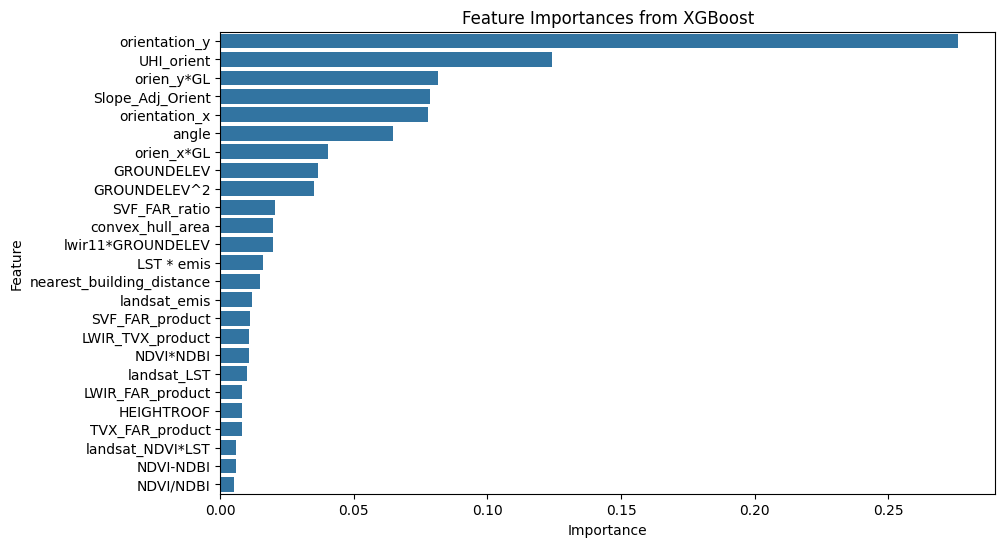

In [22]:
feature_names = ['landsat_emis', 'landsat_LST', 'landsat_NDVI*LST',
       'HEIGHTROOF', 'GROUNDELEV', 'convex_hull_area',
       'nearest_building_distance', 'orientation_x', 'orientation_y',
       'UHI_orient', 'LST * emis', 'Slope_Adj_Orient', 'orien_x*GL',
       'orien_y*GL', 'angle', 'NDVI/NDBI', 'NDVI-NDBI', 'NDVI*NDBI',
       'lwir11*GROUNDELEV', 'SVF_FAR_product', 'TVX_FAR_product',
       'SVF_FAR_ratio', 'LWIR_FAR_product', 'LWIR_TVX_product',
       'GROUNDELEV^2']

import matplotlib.pyplot as plt
import seaborn as sns

# Get feature importances from the trained model
importances = best_xgb_model.feature_importances_

# Create a DataFrame with the feature names and their importances
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})

# Sort the DataFrame by importance in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plotting the feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title('Feature Importances from XGBoost')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

# Removing unimportant features and retraining the model to improve the R2 score

In [23]:
import xgboost as xgb
import numpy as np
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

# Assuming best_xgb_model is your pre-trained model

# 1. Get feature importances from the pre-trained model
importances = best_xgb_model.feature_importances_

# 2. Identify low-importance features (adjust the threshold as needed)
low_importance_indices = np.where(importances <= 0.015)[0]  # Features with importance < 0.05

# 3. Remove low-importance features from training and test data
X_train_reduced = np.delete(X_train, low_importance_indices, axis=1)  # Removing from training data
X_test_reduced = np.delete(X_test, low_importance_indices, axis=1)  # Removing from test data

# 4. Define best parameters
best_params = {
    'subsample': 0.85,
    'reg_lambda': 0.1,
    'reg_alpha': 0,
    'n_estimators': 300,
    'max_depth': 8,
    'learning_rate': 0.1,
    'gamma': 0,
    'colsample_bytree': 0.7
}

# 5. Initialize the XGBoost model with the best parameters
model_retrained = xgb.XGBRegressor(objective='reg:squarederror',
                                  **best_params,
                                  random_state=52)

# 6. Train the model using the reduced feature set
model_retrained.fit(X_train_reduced, y_train)

# 7. Make predictions using the test data
y_pred_retrained = model_retrained.predict(X_test_reduced)

# 8. Calculate the R² score for the retrained model
retrained_r2 = r2_score(y_test, y_pred_retrained)

# Output the results
print(f"R² Score of the retrained model with reduced features: {retrained_r2}")

R² Score of the retrained model with reduced features: 0.9557878506179439


# <----------------------------------------------------------------------->

# Checking the model accurcay with new validation dataset

In [ ]:
landsat_path = '/content/drive/MyDrive/Colab Notebooks/Landsat_LST.tiff'
sentinel_path = '/content/drive/MyDrive/Colab Notebooks/S2_median_composite.tiff'
csv_path = '/content/drive/MyDrive/Colab Notebooks/Submission_template.csv'

# Validation set

In [ ]:
# Load validation data
submission_df = pd.read_csv("Submission_template.csv")

# Check the first few rows to confirm columns
submission_df

,Longitude,Latitude,UHI
0,-73.971665,40.788763,NaN
1,-73.971928,40.788875,NaN
2,-73.967080,40.789080,NaN
3,-73.972550,40.789082,NaN
4,-73.969697,40.787953,NaN
...,...,...,...
1035,-73.919388,40.813803,NaN
1036,-73.931033,40.833178,NaN
1037,-73.934647,40.854542,NaN
1038,-73.917223,40.815413,NaN


In [ ]:
import pandas as pd
import rioxarray as rxr
from pyproj import Proj, Transformer
from tqdm import tqdm

def map_satellite_data(sentinel_path, landsat_path, csv_path):
    # Load the GeoTIFF data for Sentinel and Landsat
    sentinel_data = rxr.open_rasterio(sentinel_path)
    landsat_data = rxr.open_rasterio(landsat_path)

    # Ensure CRS matches
    sentinel_crs = sentinel_data.rio.crs
    landsat_crs = landsat_data.rio.crs

    # Read the CSV file with latitudes and longitudes
    df = pd.read_csv(csv_path)
    latitudes = df['Latitude'].values
    longitudes = df['Longitude'].values

    # Define the coordinate transformation from EPSG:4326 (lat/lon) to the CRS of Sentinel and Landsat
    transformer_sentinel = Transformer.from_proj(Proj(init='epsg:4326'), Proj(sentinel_crs))
    transformer_landsat = Transformer.from_proj(Proj(init='epsg:4326'), Proj(landsat_crs))

    # Transform latitudes and longitudes into the CRS of the Sentinel and Landsat datasets
    x_sentinel, y_sentinel = transformer_sentinel.transform(longitudes, latitudes)
    x_landsat, y_landsat = transformer_landsat.transform(longitudes, latitudes)

    # Initialize lists to store band values
    sentinel_band_values = {f'Sentinel_B{band}': [] for band in [14, 15, 16, 18]}  # Bands 12-20 for Sentinel
    landsat_band_values = {f'Landsat_B{band}': [] for band in [7, 8, 9, 10, 11, 15, 17]}  # Bands 7-16 for Landsat

    # Extract band values for Sentinel and Landsat
    for lat, lon in tqdm(zip(latitudes, longitudes), total=len(latitudes), desc="Mapping values"):

        # Sentinel: Extract bands 12 to 20
        for band in list([14, 15, 16, 18]):
            band_value = sentinel_data.sel(x=lon, y=lat, band=band, method="nearest").values
            sentinel_band_values[f'Sentinel_B{band}'].append(band_value)

        # Landsat: Extract bands 7 to 16
        for band in list([7, 8, 9, 10, 11, 15, 17]):
            band_value = landsat_data.sel(x=lon, y=lat, band=band, method="nearest").values
            landsat_band_values[f'Landsat_B{band}'].append(band_value)

    # Create DataFrame with combined bands for Sentinel and Landsat
    df_combined = pd.DataFrame(sentinel_band_values)
    df_combined = pd.concat([df_combined, pd.DataFrame(landsat_band_values)], axis=1)

    return df_combined


In [ ]:
val_data = map_satellite_data(sentinel_path, landsat_path, csv_path)

/usr/local/lib/python3.11/dist-packages/pyproj/crs/crs.py:143: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/usr/local/lib/python3.11/dist-packages/pyproj/crs/crs.py:143: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
Mapping values: 100%|██████████| 1040/1040 [00:23<00:00, 45.14it/s]


In [ ]:
import geopandas as gpd
from shapely.geometry import Point
import pandas as pd

# Assuming val_data contains the mapped satellite features but no explicit 'Longitude' and 'Latitude' columns

# If val_data already has columns that indirectly reference coordinates (like "row", "column" or any pixel data)
# We would need to derive or load that information. If not, I'll assume the coordinates are available somewhere else.

# Let's assume you have the coordinates from the submission CSV and will merge that with val_data.

# Load your coordinates from the submission file (if separate)
submission_df  # Assuming you have a file with latitude/longitude

# Ensure that the coordinates are in the correct format (round them for consistency)
submission_df['Longitude'] = submission_df['Longitude'].round(6)
submission_df['Latitude'] = submission_df['Latitude'].round(6)

# Assuming 'val_data' contains only satellite features, and you have a one-to-one mapping with submission_df
# Let's merge the coordinates from submission_df with val_data
val_data_with_coords = pd.concat([val_data, submission_df[['Longitude', 'Latitude']]], axis=1)

# Convert val_data_with_coords to GeoDataFrame (this will include your satellite data and the coordinates)
geometry = [Point(xy) for xy in zip(val_data_with_coords['Longitude'], val_data_with_coords['Latitude'])]
val_gdf = gpd.GeoDataFrame(val_data_with_coords, geometry=geometry, crs="EPSG:4326")

# Convert Building Footprint to GeoDataFrame
building_geometry = [Point(xy) for xy in zip(building_data['longitude'], building_data['latitude'])]
building_gdf = gpd.GeoDataFrame(building_data, geometry=building_geometry, crs="EPSG:4326")

# Use nearest join to merge val_data with building data based on proximity of coordinates
joined_data = gpd.sjoin_nearest(val_gdf, building_gdf, how='left', distance_col="distance")

# Drop unnecessary columns (e.g., index_right and geometry)
joined_data = joined_data.drop(columns=['index_right', 'geometry'])

/usr/local/lib/python3.11/dist-packages/geopandas/array.py:403: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  warnings.warn(


In [ ]:
# Renaming columns for Landsat Features
rename_dict = {
    'Landsat_B7': 'lwir11',
    'Landsat_B8': 'landsat_emis',
    'Landsat_B9': 'landsat_LST',
    'Landsat_B10': 'landsat_NDVI',
    'Landsat_B11': 'landsat_NDBI',
    'Landsat_B15': 'TVX',
    'Landsat_B17': 'landsat_NDVI*LST',
    'Sentinel_B14': 'sentinel_NDWI',
    'Sentinel_B15': 'sentinel_MNDWI',
    'Sentinel_B16': 'sentinel_SAVI',
    'Sentinel_B18': 'sentinel_Brightness'
}


# Renaming the columns in the DataFrames
joined_data.rename(columns= rename_dict, inplace=True)

In [ ]:
joined_data['GROUNDELEV'] = joined_data['GROUNDELEV'].fillna(joined_data['GROUNDELEV'].median())

In [ ]:
joined_data.drop(columns = ['Longitude', 'Latitude', 'latitude', 'longitude', 'region_label'], inplace = True)

In [ ]:
for col in joined_data.select_dtypes(include=['object']).columns:
    joined_data[col] = joined_data[col].astype(float)

In [ ]:
joined_data['UHI_orient'] = joined_data['orientation_x'] * joined_data['orientation_y']
joined_data['LST * emis'] = joined_data['landsat_LST'] * joined_data['landsat_emis']
joined_data['Slope_Adj_Orient'] = (joined_data['orientation_x'] + joined_data['orientation_y']) / joined_data['GROUNDELEV']
joined_data['orien_x*GL'] = joined_data['orientation_x'] * joined_data['GROUNDELEV']
joined_data['orien_y*GL'] = joined_data['orientation_y'] * joined_data['Slope_Adj_Orient']
joined_data['angle'] = joined_data['orientation_y'] / joined_data['orientation_x']
joined_data['NDVI/NDBI'] = joined_data['landsat_NDVI'] / (joined_data['landsat_NDBI'] + 1e-6)
joined_data['NDVI-NDBI'] = joined_data['landsat_NDVI'] - joined_data['landsat_NDBI']
joined_data['NDVI*NDBI'] = joined_data['landsat_NDVI'] * joined_data['landsat_NDBI']
joined_data['NDVI-NDBI'] = joined_data['landsat_NDBI'] - joined_data['sentinel_NDWI']
joined_data['lwir11*GROUNDELEV'] = joined_data['lwir11'] * joined_data['GROUNDELEV']
joined_data["SVF_FAR_product"] = joined_data["SVF"] * joined_data["FAR"]
joined_data["TVX_FAR_product"] = joined_data["TVX"] * joined_data["FAR"]
joined_data["SVF_FAR_ratio"] = joined_data["SVF"] / (joined_data["FAR"] + 1e-6)
joined_data["LWIR_FAR_product"] = joined_data["lwir11"] * joined_data["FAR"]
joined_data["LWIR_TVX_product"] = joined_data["lwir11"] * joined_data["TVX"]
joined_data['GROUNDELEV^2'] = joined_data['GROUNDELEV']**2

In [ ]:
joined_data = joined_data.drop(['FEAT_CODE', 'building_density', 'lwir11', 'sentinel_MNDWI', 'distance', 'compactness', 'building_perimeter', 'building_area', 'sentinel_Brightness', 'sentinel_SAVI', 'SVF', 'TVX', 'FAR', 'sentinel_NDWI', 'landsat_NDBI', 'landsat_NDVI'], axis = 1)

In [ ]:
joined_data.replace([np.inf, -np.inf], np.nan, inplace=True)
joined_data = joined_data.apply(lambda col: col.fillna(col.median()), axis=0)

In [ ]:
transformed_submission_data = scaler.transform(joined_data)

In [ ]:
joined_data = joined_data.drop(['nearest_building_distance', 'landsat_emis', 'SVF_FAR_product', 'LWIR_TVX_product', 'NDVI*NDBI', 'landsat_LST', 'LWIR_FAR_product', 'HEIGHTROOF', 'TVX_FAR_product', 'landsat_NDVI*LST', 'NDVI-NDBI', 'NDVI/NDBI'], axis = 1)

# Using the existing trained model to predict the Unknown UHI from the coordiantes given in the validation set.

In [ ]:
#Making predictions
final_predictions = best_xgb_model.predict(transformed_submission_data)
final_prediction_series = pd.Series(final_predictions)

In [ ]:
submission_dataframe = pd.DataFrame({'Longitude':submission_df['Longitude'].values, 'Latitude':submission_df['Latitude'].values, 'UHI Index':final_prediction_series.values})

In [ ]:
submission_dataframe

,Longitude,Latitude,UHI Index
0,-73.971665,40.788763,0.963781
1,-73.971928,40.788875,0.963500
2,-73.967080,40.789080,0.964818
3,-73.972550,40.789082,0.963439
4,-73.969697,40.787953,0.957667
...,...,...,...
1035,-73.919388,40.813803,1.037418
1036,-73.931033,40.833178,1.042982
1037,-73.934647,40.854542,1.027802
1038,-73.917223,40.815413,1.037887


# Saving the prediction into csv file

In [ ]:
submission_dataframe.to_csv("submission_4.csv", index=False, float_format="%.15f")

In [ ]:
from google.colab import files
files.download("submission_4.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

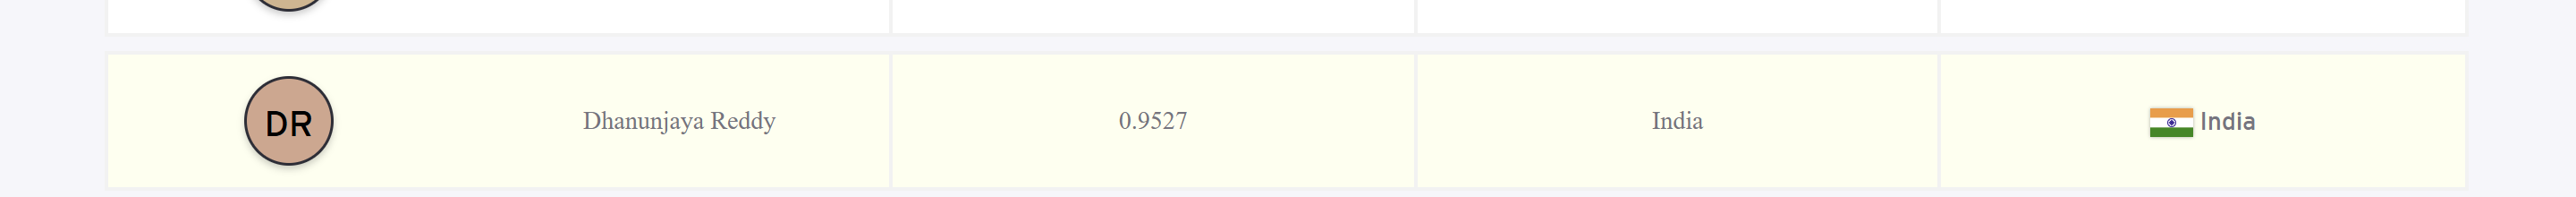

# The top score in the competition was 0.9926 and this model might be built using extra data and some additional feature engineering, but i built my model in last six days of the competition with limited data, and the total r2 score that I acheived from this validation datset is 0.9527, very much similar to my testing accuracy.